In [1]:
%matplotlib notebook

from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian
newton = UNITS.newton

In [3]:
condition = Condition(x = 0 * m, 
                      y = 1 * m,
                      g = 9.8 * m/s**2,
                      mass = 79.4 * kg,
                      diameter = 0.4472 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.25,
                      angle = 45 * degree,
                      velocity = 60 * m / s,
                      duration = 8.5 * s)

In [4]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

### PHASE 1

In [5]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [64]:
system = make_system(condition)
run_odeint(system, slope_func)

In [65]:
xs = system.results.x
ys = system.results.y

In [61]:
ys.head

<bound method NDFrame.head of 0.0      1.000000
0.1      5.189412
0.2      9.272582
0.3     13.249831
0.4     17.121470
0.5     20.887802
0.6     24.549125
0.7     28.105727
0.8     31.557889
0.9     34.905886
1.0     38.149985
1.1     41.290447
1.2     44.327526
1.3     47.261467
1.4     50.092513
1.5     52.820897
1.6     55.446848
1.7     57.970586
1.8     60.392329
1.9     62.712288
2.0     64.930665
2.1     67.047663
2.2     69.063474
2.3     70.978287
2.4     72.792288
2.5     74.505655
2.6     76.118564
2.7     77.631185
2.8     79.043686
2.9     80.356228
          ...    
7.1     47.098073
7.2     44.247166
7.3     41.302921
7.4     38.265543
7.5     35.135237
7.6     31.912214
7.7     28.596689
7.8     25.188882
7.9     21.689014
8.0     18.097314
8.1     14.414012
8.2     10.639344
8.3      6.773550
8.4      2.816873
8.5     -1.230439
8.6     -5.368133
8.7     -9.595955
8.8    -13.913644
8.9    -18.320936
9.0    -22.817562
9.1    -27.403252
9.2    -32.077728
9.3    -36.84071

In [66]:
#plotting x and y as functions of time
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


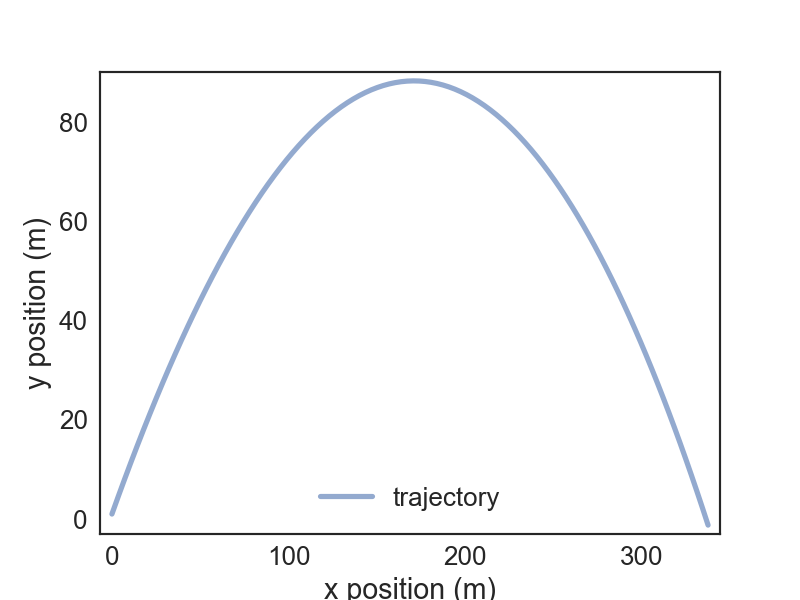

In [67]:
#trajectory plot
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

In [69]:
#animation
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 400],
         ylim=[-5, 100],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

<IPython.core.display.Javascript object>

In [7]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

In [8]:
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

In [9]:
#takes launch angle, returns range
def range_func(angle, condition):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: distance in meters
    """
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    x_range = interpolate_range(system.results)
    return x_range

In [55]:
range_func(45, condition)

array(336.3824698970658)

### PHASE 2

In [37]:
condition2 = Condition(x = 0 * m, 
                      y = 1 * m,
                      g = 9.8 * m/s**2,
                      mass = 108.1 * kg, #10 kg fuel, 18.7 kg jetpack, 79.4 kg person
                      diameter = 0.4472 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.25,
                      angle = 45 * degree,
                      velocity = 60 * m / s,
                      duration = 15* s, #this was 8.5
                      ignite_t = 5 * s)

In [38]:
def make_jetpack_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy, M=0)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    #sets jetpack force
    Fj = 1334.5 * newton
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts, Fj=Fj)

In [39]:
def jetpack_slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy, M = state
    unpack(system)
    
    #Implement Rocket Equation to account for loss of momentum if time
    current_mass= mass - M
    dMdt = 0 * kg / s
    if t > ignite_t and t < ignite_t + 4 * s:
        dMdt = 2.5 * kg / s
        
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
 
    angle = v.angle
    
    #fixes error scenario
    error = Vector(10**-8, 0) * m/s
    if v.mag < error.mag:
        angle = 1.570796 * radian
    
    mag = Fj
    
    xf, yf = pol2cart(angle, -mag)

    f_jetpack = Vector(xf, yf)
    
    if t < ignite_t:
        f_jetpack=0 * newton
    if t >= ignite_t + 4 * s:
        f_jetpack=0 * newton
        
    a_jetpack = f_jetpack / current_mass
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / current_mass
    
    a = a_grav + a_drag + a_jetpack
    
    return vx, vy, a.x, a.y, dMdt

In [40]:
system = make_jetpack_system(condition2)
run_odeint(system, jetpack_slope_func)

xs = system.results.x
ys = system.results.y
xvs = system.results.vx
yvs = system.results.vy
ms = system.results.M

In [10]:
def find_ground(system):
    unpack(system)
    for y in system.results.y:
            if y < 0.00001 or y > -0.00001:
                return y.loc()
            else:
                print('sorry')
        

In [11]:
find_ground(system)

AttributeError: 'numpy.float64' object has no attribute 'loc'

In [257]:
ys[ys == 0]

Series([], Name: y, dtype: float64)

In [12]:
#trajectory plot
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


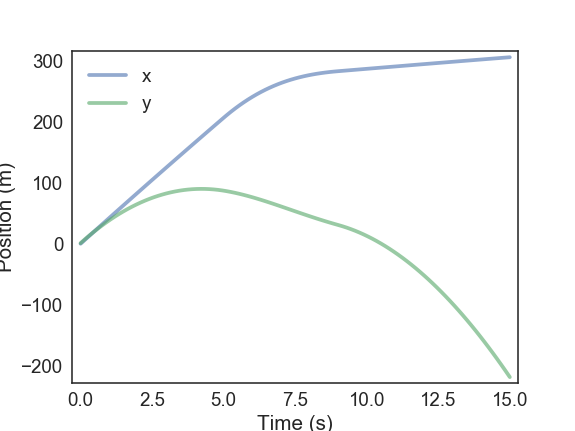

In [13]:
#plotting x and y as functions of time
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

In [259]:
ys[0]

1.0

In [14]:
x, y, vx, vy = 1, 2, 3, 4
unpack(system)
v = Vector(vx, vy)
v.mag


<Quantity(5.0, 'dimensionless')>

<IPython.core.display.Javascript object>


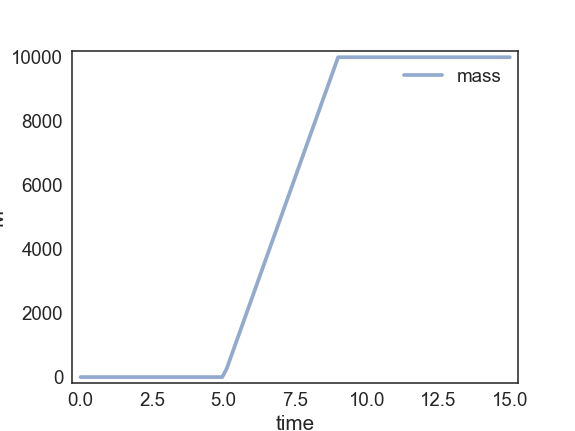

In [15]:
#Spent fuel mass plot
newfig()
plot(ms, label='mass')

decorate(xlabel='time',
         ylabel='M')

<IPython.core.display.Javascript object>


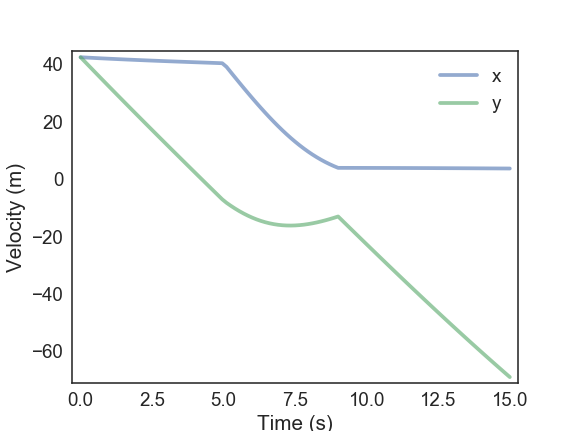

In [16]:
newfig()
plot(xvs, label='x')
plot(yvs, label='y')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m)')

In [194]:
ms.loc[4.5:9]

4.50    108100.000000
4.65    108100.000000
4.80    108100.000000
4.95    108100.000000
5.10    108349.999690
5.25    108724.999690
5.40    109099.999690
5.55    109474.999690
5.70    109849.999690
5.85    110224.999690
6.00    110599.999690
6.15    110974.999690
6.30    111349.999690
6.45    111724.999690
6.60    112099.999690
6.75    112474.999690
6.90    112849.999690
7.05    113224.999690
7.20    113599.999690
7.35    113974.999690
7.50    114349.999690
7.65    114724.999690
7.80    115099.999690
7.95    115474.999690
8.10    115849.999690
8.25    116224.999690
8.40    116599.999690
8.55    116974.999690
8.70    117349.999690
8.85    117724.999690
9.00    118099.997551
Name: M, dtype: float64

### Optimization

In [17]:
def interpolate_range(system):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = system.results.x
    ys = system.results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

In [21]:
range= interpolate_range(system)
range

array(288.6378836809203)

<IPython.core.display.Javascript object>


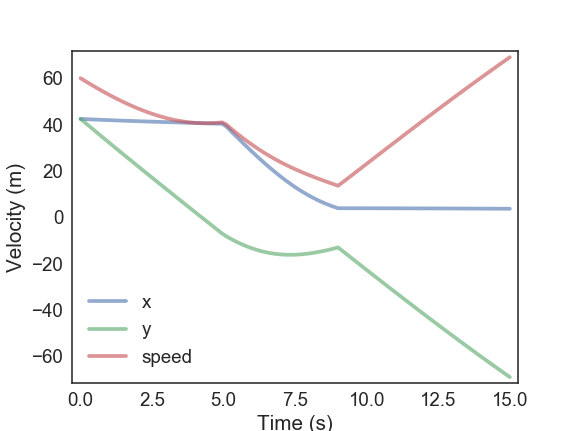

In [46]:
#test to see if I could get v magnitutde
vs = sqrt(xvs**2 + yvs**2)
newfig()
plot(xvs, label='x')
plot(yvs, label='y')
plot(vs, label='speed')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m)')

In [47]:
def interpolate_both(system):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = system.results.x
    ys = system.results.y
    yvs = system.results.vy
    xvs = system.results.vx
    vs = sqrt(xvs**2 + yvs**2)
    
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    V = interpolate(vs, kind='cubic')
    return X(t_land), V(t_land)

In [48]:
list = interpolate_both(system)
list

(array(288.6378836809203), array(27.930930358505883))

In [41]:
def range_func(ignite_t, condition):  
    
    condition.set(ignite_t = ignite_t * s)
    system = make_jetpack_system(condition)
    run_odeint(system, jetpack_slope_func)
    x_range = interpolate_range(system)
    print(ignite_t)
    return x_range

In [42]:
range_func(5, condition2)

5


array(288.6378836809203)

In [50]:
#given an ingition time, returns the distance of the launch and the speed at impact
def end_state_func(ignite_t, condition):  
    
    condition.set(ignite_t = ignite_t * s)
    system = make_jetpack_system(condition)
    run_odeint(system, jetpack_slope_func)
    end_state = interpolate_both(system)
    print(ignite_t)
    return end_state

In [51]:
end_state_func(5, condition2)

5


(array(288.6378836809203), array(27.930930358505883))

In [ ]:
def farthest_distance(ignite_t, condition):
#I think just having the thing that interpolates both of them makes it so we don't have to worry about this  

In [ ]:
def landing_v(ignite_t, condition):
#I think just having the thing that interpolates both of them makes it so we don't have to worry about this

In [53]:
#takes a list of possible ignite times, returns the distance and speed at each condition
def ultimate_sweep(t_array, condition):
    distances = SweepSeries()
    speeds = SweepSeries()
    for t in t_array:
        distances[t], speeds[t] = end_state_func(t, condition)
        
    #will get weird if you change the system name. This is fine with end_state_func,
    #because it just makes a system called system, so we should be fine, but be careful.
    system.distances = distances
    system.speeds = speeds

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0


<IPython.core.display.Javascript object>


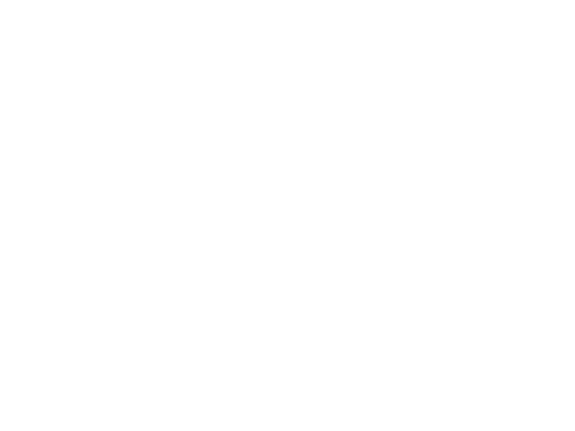

NameError: name 'distances' is not defined

In [56]:
t_array = linspace(0, 7, 71)
ultimate_sweep(t_array, condition2)


<IPython.core.display.Javascript object>


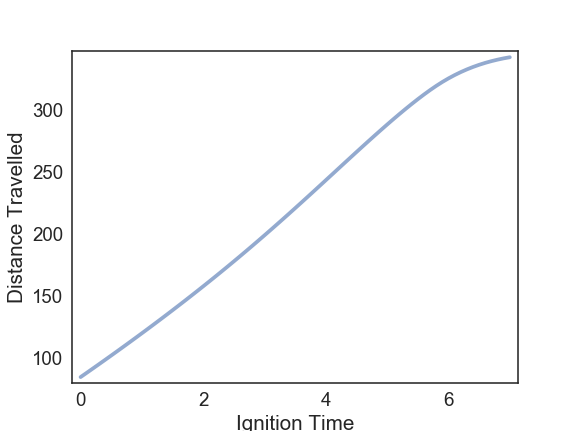

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [58]:
newfig()
plot(system.distances)
decorate(xlabel = 'Ignition Time',
         ylabel = 'Distance Travelled')

<IPython.core.display.Javascript object>


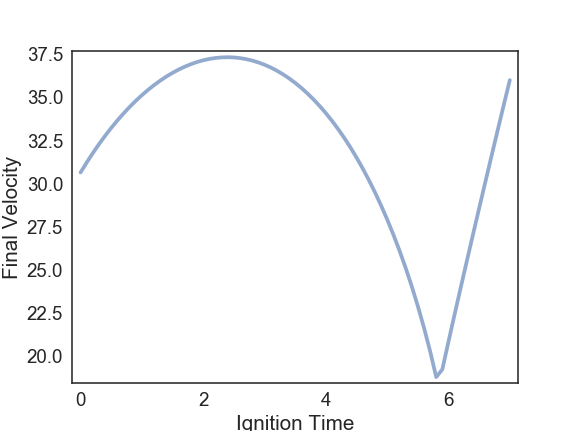

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [59]:
newfig()
plot(system.speeds)
decorate(xlabel = 'Ignition Time',
         ylabel = 'Final Velocity')

In [60]:
newfig()
plot(system.speeds, system.distances)

<IPython.core.display.Javascript object>

In [64]:
#Takes same t_array as ultimate_sweep, as well as the system and whatever safe is. Gives the distance, speed, and time.
#Only gives first instance of best time, if this curves there will be trouble.
def fly_farsafe (t_array, system, safe_speed=5):
    for t in t_array:
        if system.speeds[t] > safe_speed:
            system.distances[t] = 0
    
    best_distance = system.distances.argmax()
    best_time = system.distances.idxmax()
    best_speed = system.speeds[best_time]
    
    return best_distance, best_speed, best_time

In [65]:
t_array = linspace(0, 7, 71)
list = fly_farsafe(t_array, system)
list

(0.0, array(30.65240120093381), 0.0)